<a href="https://colab.research.google.com/github/smal3iutre2/washu-5509/blob/main/HW/CSE5509_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Use and Land Cover Classification using Pytorch


In this assignment, you will learn how to:
- Train a deep learning model for Image classification using Pytorch


# Table of Contents


*   [Overview](#overview)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [Credits](#credits)
*   [References](#references)

<a name="overview"></a>
# Overview
This tutorial covers an introduction to image classification using Pytorch for land use and land cover (LULC) mapping.

Specifically, you will learn how to:
- Classify satellite images into 10 LULC categories using the [EuroSAT dataset](https://arxiv.org/abs/1709.00029)
- Design different CNN models and tune for various hyperparameters
- Fine-tune a Resnet-18 CNN model for image classification
- Save and load trained models in Pytorch




<a name="software-requirements"></a>
# Software Requirements

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

## Enabling GPU in Google Colab
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

In [3]:
import itertools
import ssl
import urllib.request
import zipfile
# Standard libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Data manipulation and visualization
import seaborn as sns
# Deep Learning libraries
import torch
import torch.nn as nn
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms
from tqdm import tqdm
# Download EuroSAT
from torchvision.datasets import EuroSAT

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Determine Torch Device
If you are running in Google Colab, check that the GPU is enabled.

In [4]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()

print(f"Using torch device type: {device}")

Using torch device type: cuda


<a name="data-description"></a>
# Data Description

In this section, you will learn how to:
- Download the EuroSAT dataset into your Google Drive
- Generate the train, validation and test sets by splitting the EuroSAT dataset
- Visualize a sample of the images and their LULC labels

## Download EuroSAT Dataset
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification.

In [5]:
# Define the root directory for the dataset
root_dir = './data'

# Instantiate the EuroSAT dataset
dataset = EuroSAT(root=root_dir, download=True)

# Check dataset size and structure
print(f"Number of samples: {len(dataset)}")
print(f"Classes: {dataset.classes}")

# Example: Access the first sample
sample = dataset[0]
print(sample)

100%|██████████| 94.3M/94.3M [00:00<00:00, 230MB/s]


Number of samples: 27000
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
(<PIL.Image.Image image mode=RGB size=64x64 at 0x7B3DFC7E99D0>, 0)


### Data Augmentation

Data augmentation is a  technique that randomly applies image transformations, e.g. crops, horizontal flips, and vertical flips, to the input images during model training. These perturbations reduce the neural network's overfitting to the training dataset, and they allow it to generalize better to the unseen test dataset.
<br><br>
<center> <img src="https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png" width="400"/>
</center>
<br>
<font size=2>Image Source: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Data augmentation-assisted deep learning of hand-drawn partially colored sketches for visual search. PLOS ONE. 12. e0183838. 10.1371/journal.pone.0183838. </font>
<br>


### Image Normalization
Additionally, in the cell below, the `transforms.Normalize` method normalizes each of the three channels to the given means and standard deviations defined in the `imagenet_mean` and `imagenet_std` variables. ImageNet is a large training dataset of images and labels.  Later in this tutorial, we will be using a model pre-trained on this dataset.  In order to use this pre-trained model for our LULC dataset, we need to ensure that the input dataset is normalized to have the same statistics (mean and standard deviation) as ImageNet.

<br>
<center> <img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" width="400"/>
<br>
<font size=2>Image Source: https://cv.gluon.ai/build/examples_datasets/imagenet.html </font>
<br>
</center>

Existing research has found that using models pretrained on massive datasets, such as ImageNet, improves accuracy when applying these neural networks to new datasets.  Pre-trained models serve as excellent generic feature extractors.  [Please read here for more information](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [1]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
def get_transforms(transforms_type='imagenet'):
    if transforms_type == 'imagenet':
        input_size = 224
    else:
        input_size = 64

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])

    valid_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])

    test_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])

    return train_transform, valid_transform, test_transform

### Load EuroSAT Dataset
Let's start by loading the EuroSAT dataset using torch's `ImageFolder` class.

`ImageFolder` is a generic data loader where the images are arranged in this way:

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


In [6]:
# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Split into Train, Validation and Test Sets
Here, we split the dataset into a train set, validation set and test set. The training set will be 70% of the Eurosat dataset, randomly selected. The valdation set will be 10% of the Eurosat dataset, randomly selected. The remaining 20% of the dataset will be our test set.

In [7]:
def data_prep(batch_size=32,num_workers=2,transforms_type='original'):

    train_transform, valid_transform, test_transform = get_transforms(transforms_type='original')
    # Apply different transformations to the training, validation and test sets
    train_data = EuroSAT(root=root_dir, transform=train_transform)
    validation_data = EuroSAT(root=root_dir, transform=valid_transform)
    test_data = EuroSAT(root=root_dir, transform=test_transform)

    # Randomly split the dataset into 70% train/ 10% validation / 20% test
    # by subsetting the transformed train and test datasets
    indices = list(range(int(len(dataset))))
    split1 = int(0.7 * len(dataset))
    split2 = int(0.8 * len(dataset))
    np.random.shuffle(indices)

    train_data = data.Subset(train_data, indices=indices[:split1])
    validation_data = data.Subset(validation_data, indices=indices[split1:split2])
    test_data = data.Subset(test_data, indices=indices[split2:])

    train_loader = data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, valid_loader, test_loader

Finally, we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets.

In [8]:
num_workers = 2
batch_size = 32
transforms_type='original'
train_loader, valid_loader, test_loader = data_prep(batch_size=batch_size,num_workers=num_workers,transforms_type=transforms_type)

## Visualize Data

In the cell below, we will visualize a batch of the dataset.  The cell visualizes the input to the neural network (the RGB image) along with the associated label.

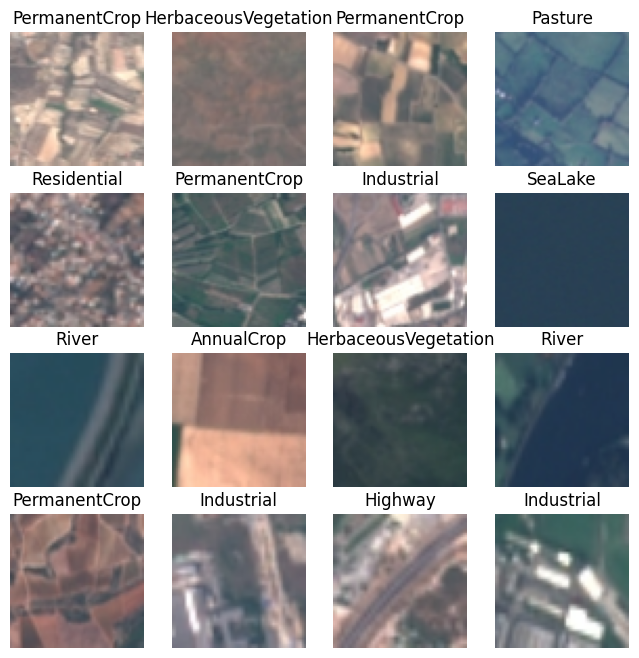

In [9]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8,8))

for i in range(n):
    for j in range(n):
        image = inputs[i * n + j].numpy().transpose((1, 2, 0))
        image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

        title = class_names[classes[i * n + j]]
        axes[i, j].imshow(image)
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

# Exploratory Data Analysis

Next, let's explore our dataset a little bit more.  In particular, how many images of each class are included?

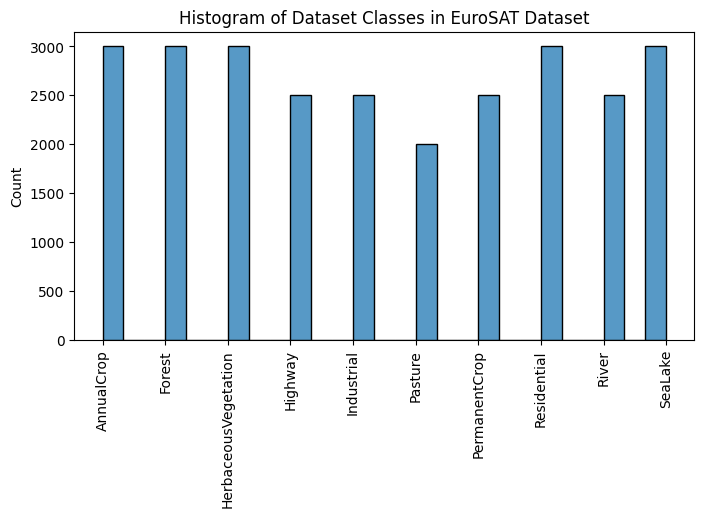

In [14]:
plt.figure(figsize=(8, 4))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

Below is a simple baseline network similar to the one used in [this pytorch tutorial.](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# Baseline

In [11]:
# Baseline: A simple ConvNet baseline
class baseline(nn.Module):
    def __init__(self,hparams):
        super().__init__()
        self.hparams = hparams
        self.conv1 = nn.Conv2d(3, 6, 5)
        if self.hparams['pooling'] == 'maxpool':
            self.pool = nn.MaxPool2d(2, 2)
        elif self.hparams['pooling'] == 'avgpool':
            self.pool = nn.AvgPool2d(2, 2)
        else:
            raise NotImplementedError

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        if self.hparams['activation'] == 'relu':
            self.activation = nn.ReLU()
        elif self.hparams['activation'] == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif self.hparams['activation'] == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplementedError

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


hparams ={'activation':'relu','pooling':'maxpool'}
model = baseline(hparams).to(device)
torchsummary.summary(model, (3, 64, 64), device=str(device))

inputs = torch.rand(2,3,64,64, device=device)
model(inputs).shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
              ReLU-2            [-1, 6, 60, 60]               0
         MaxPool2d-3            [-1, 6, 30, 30]               0
            Conv2d-4           [-1, 16, 26, 26]           2,416
              ReLU-5           [-1, 16, 26, 26]               0
         MaxPool2d-6           [-1, 16, 13, 13]               0
            Linear-7                  [-1, 120]         324,600
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 338,486
Trainable params: 338,486
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/

torch.Size([2, 10])

# Model Development
Based on the specification provided, design a set of your own models with varying size and architectural choices.

Architectural choices:
*   (in_channels, out_channels, kernel_size, stride) for your convolution layers
*  activation function choices:[ReLU, LeakyReLU, Tanh]
*  pooling layers: [AvgPool2d, MaxPool2d]


## Task 1: Model 1
This model should have 3 2D-convolution layers and maximum of 2 hidden linear layers. Feel free to choose suitable parameters for 2D-conv and linear layers.

_Points:_ 10

In [46]:
# Design your model1 based on hparams1 = {'activation':'', 'pooling':''}.
class model1(nn.Module):
    def __init__(self,hparams1=None):
        super().__init__()
        ######## CODE BELOW ############
        self.hparams = hparams1
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if hparams1['pooling'] == 'maxpool':
            self.pool = nn.MaxPool2d(2, 2)
        elif hparams1['pooling'] == 'avgpool':
            self.pool = nn.AvgPool2d(2, 2)

        if self.hparams['activation'] == 'relu':
            self.activation = nn.ReLU()
        elif self.hparams['activation'] == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif self.hparams['activation'] == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplementedError

        ######## CODE ABOVE ############

    def forward(self, x):

        ####### CODE BELOW ############
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        ####### CODE ABOVE ############

        return x

hparams1 = {'activation': 'relu', 'pooling': 'maxpool'}
# model1 = model1(hparams1).to(device)
# torchsummary.summary(model1, (3, 64, 64))
# inputs = torch.rand(2,3,64,64).to(device)
# model(inputs).shape

In [13]:
def test1_public(hparams1):
    model = model1(hparams1)
    dummy_input = torch.randn(4, 3, 64, 64)
    output = model(dummy_input)
    assert output.shape == (4, 10), f"Expected output shape (4, 10), got {output.shape}"

## Task 2: Model 2
This model should have 4 to 8 2D-convolution layers and 2 to 5 hidden linear layers. Feel free to choose suitable parameters for 2D-conv and linear layers.

_Points:_ 10

In [17]:
# Design your model2 based on hparams2 = {'activation':'', 'pooling':''}.
class model2(nn.Module):
    def __init__(self,hparams2=None):
        super().__init__()
        ######## CODE BELOW ############
        self.hparams = hparams2
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        if hparams2['pooling'] == 'maxpool':
            self.pool = nn.MaxPool2d(2, 2)
        elif hparams2['pooling'] == 'avgpool':
            self.pool = nn.AvgPool2d(2, 2)
        if self.hparams['activation'] == 'relu':
            self.activation = nn.ReLU()
        elif self.hparams['activation'] == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif self.hparams['activation'] == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise NotImplementedError
        ######## CODE ABOVE ############

    def forward(self, x):

        ####### CODE BELOW ############
        x = self.activation(self.conv1(x))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.activation(self.conv3(x))
        x = self.pool(self.activation(self.conv4(x)))
        x = self.pool(self.activation(self.conv5(x)))

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        ####### CODE ABOVE ############

        return x

# hparams2 = {'activation': 'relu', 'pooling': 'maxpool'}
# model2 = model2(hparams2).to(device)
# torchsummary.summary(model2, (3, 64, 64))
# inputs = torch.rand(2,3,64,64).to(device)
# model(inputs).shape

In [18]:
def test2_public():
    hparams2 = {'activation': 'relu', 'pooling': 'maxpool'}
    model = model2(hparams2)
    dummy_input = torch.randn(4, 3, 64, 64)
    model.eval()
    with torch.no_grad():
        output = model(dummy_input)
    assert output.shape == (4, 10), f'Expected output shape (4, 10), got {output.shape}'

test2_public()

In [19]:
def get_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
    model = model.to(device)
    return model

In [20]:
def get_model(model_type='baseline', hparams=None):
    if hparams is None:
        hparams = {}

    if not model_type == 'resnet18':
        model_hparams = {}
        model_hparams['activation'] = hparams['activation']
        model_hparams['pooling'] = hparams['pooling']

    if model_type == 'baseline':
        model = baseline(model_hparams).to(device)
        return model.to(device)

    elif model_type == 'model1':
        model = model1(hparams1=model_hparams).to(device)
        return model.to(device)

    elif model_type == 'model2':
        model = model2(hparams2=model_hparams).to(device)
        return model.to(device)


    elif model_type == 'resnet18':
        model = get_resnet18()
        return model.to(device)

In [21]:
model = get_model(model_type='resnet18')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

### Cross Entropy Loss
We define our loss as the cross-entropy loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. ([Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

For two classes, it is computed as:

$−ylog(p)-(1−y)log(1−p)$

For multiclass classification with $M$ classes, it is defined as:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - number of classes (dog, cat, fish)
- $log$ - the natural log
- $y_{o,c}$ - binary indicator (0 or 1) if class label $c$ is the classification for observation $o$
- $p_{o,c}$- predicted probability observation $o$ is of class $c$

In [22]:
# Specify criterion
criterion = torch.nn.CrossEntropyLoss()

### Stochastic Gradient Descent
Remember that the goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Image source:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

## Task 3: Train Model
Define `train()` to return loss and accuracy.

_Points:_ 10

In [23]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_total_correct = 0.0
    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        ################YOUR CODE BELOW HERE####################

        # Step1: Zero the parameter gradients; Clear off previous weights in order to obtain updated weights.
        optimizer.zero_grad()


        # Step2: Forward pass
        outputs = model(inputs)

        # Step3: Compute the loss
        loss = criterion(outputs, labels)

        # Step4: Compute the gradients wrt the loss
        loss.backward()

        # Step5: Use optimizer to update the weights based on the internally stored gradients
        optimizer.step()

        ################YOUR CODE ABOVE HERE####################

        # Calculate statistics
        _, preds = torch.max(outputs, 1)

        # Calculate running loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

    return epoch_loss, epoch_accuracy

In [24]:
# Helper for testing train function (do not modify)
def create_mini_loader(batch_size=4, num_batches=2):
    """Creates a tiny dataloader for testing purposes."""
    X = torch.randn(batch_size * num_batches, 3, 64, 64)
    y = torch.randint(0, 10, (batch_size * num_batches,))
    mini_dataset = torch.utils.data.TensorDataset(X, y)
    return torch.utils.data.DataLoader(mini_dataset, batch_size=batch_size)

In [25]:
def test3_public():
    hparams = {'activation': 'relu', 'pooling': 'maxpool'}
    test_model = baseline(hparams).to(device)
    mini_loader = create_mini_loader(batch_size=4, num_batches=2)
    test_criterion = nn.CrossEntropyLoss()
    test_optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    result = train(test_model, mini_loader, test_criterion, test_optimizer)
    assert isinstance(result, tuple), f'train() should return a tuple, got {type(result)}'
    assert len(result) == 2, f'train() should return 2 values (loss, accuracy), got {len(result)}'
    loss, accuracy = result
    assert isinstance(loss, float), f'Loss should be a float, got {type(loss)}'
    assert loss >= 0, f'Loss should be non-negative, got {loss}'

test3_public()

100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


## Evaluate Model

In [26]:
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_total_correct = 0.0

    for i, (inputs, labels) in enumerate(tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

    return epoch_loss, epoch_accuracy

Putting it all together, we can now commence training and evaluation in the following cell.

In [27]:
def main(hparams):
    # Keep track of the best loss and
    # best model weights with the lowest loss
    best_loss = np.inf
    best_acc = 0.0
    best_model = None
    #get data
    train_loader, valid_loader, test_loader = data_prep(batch_size=hparams['batch_size'],num_workers=hparams['num_workers'],transforms_type=hparams['transforms_type'])
    #get model
    model = get_model(model_type=hparams['model_type'],hparams=hparams)

    # Specify optimizer
    if hparams['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
    elif hparams['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])
    else:
        raise NotImplementedError
    results = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
    # Train and test over n_epochs
    for epoch in range(hparams['n_epochs']):
        print("Epoch {}".format(epoch+1))
        train_loss, train_acc = train(model, train_loader,criterion,optimizer)
        val_loss, val_acc = evaluate(model, valid_loader, criterion)

        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_acc = val_acc

    return results, best_acc, best_model, test_loader

In [28]:
def gather_results(results):
    results['train_acc'] = [a.cpu() for a in results['train_acc']]
    results['val_acc'] = [a.cpu() for a in results['val_acc']]
    x = list(range(len(results['val_acc'])))
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # plot lines

    ax[0].plot(x, results['train_loss'], label = "train_loss")
    ax[0].plot(x, results['val_loss'], label = "val_loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend()
    ax[0].set_title("loss")

    # plot lines
    ax[1].plot(x, results['train_acc'], label = "train_acc")
    ax[1].plot(x, results['val_acc'], label = "val_acc")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    ax[1].set_title("accuracy")
    plt.show()

## Save Model

We can now save the model to our local Google drive as follows.


In [29]:
def save_model(hparams, best_model):
    model_dir = "./models/"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_file = model_dir + 'best_model.pth'
    torch.save(best_model, model_file)
    print(hparams['model_type']+' Model successfully saved to {}'.format(model_file))

## Load Model
Here we show you how to load the saved model from the previous step.

In [30]:
def load_model(hparams):
    model_dir = "./models/"
    model_file = model_dir + 'best_model.pth'
    model = torch.load(model_file, map_location=device)
    model.eval()
    print('Model file {} successfully loaded.'.format(model_file))
    return model

## Task 4: Hyperparameter search
Define a simple hyperparameter search function hyper_sweep() that does grid sampling.

_Points:_ 5

In [31]:
def get_hparams(model_type='baseline',n_epochs=10,learning_rate=1e-2, optimizer='sgd', activation='relu',pooling='maxpool'):
    hparams = {}
    hparams['num_workers'] = 0
    hparams['batch_size'] = 32
    hparams['transforms_type'] = 'original'
    hparams['model_type'] = model_type
    hparams['n_epochs'] = n_epochs
    hparams['learning_rate'] = learning_rate
    hparams['optimizer'] = optimizer
    hparams['activation'] = activation
    hparams['pooling'] = pooling
    return hparams

In [35]:
def hyper_sweep(hyper_params):
    """
    Perform grid search over hyperparameters.

    Args:
        hyper_params: Dictionary where keys are parameter names and values are lists of values to try

    Returns:
        results_final: DataFrame containing all hyperparameter combinations and their validation accuracies
        best_model_final: The model with the best validation accuracy

    Requirements:
        - Save results_final to 'hyper_sweep_results.csv' before returning
        - The CSV must include a 'val_acc' column with validation accuracies
    """
    ################YOUR CODE BELOW HERE####################
    keys = hyper_params.keys()
    values = hyper_params.values()
    combinations = list(itertools.product(*values))

    results = []
    best_val_acc = 0.0
    best_model_final = None

    for combo in combinations:
        current_config = dict(zip(keys, combo))
        run_config = current_config.copy()

        if 'optimizers' in run_config:
            run_config['optimizer'] = run_config.pop('optimizers')

        if 'activations' in run_config:
            run_config['activation'] = run_config.pop('activations')

        hparams = get_hparams(**run_config)

        print(f"Testing with: {current_config}")

        model = get_model(hparams['model_type'], hparams)
        criterion = torch.nn.CrossEntropyLoss()
        if hparams['optimizer'] == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=hparams['learning_rate'])

        criterion = nn.CrossEntropyLoss()
        lr = hparams['learning_rate']

        final_val_acc = 0.0

        for epoch in range(hparams['n_epochs']):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer)

            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            final_val_acc = val_acc
        print(f"--> Done. Validation Accuracy: {final_val_acc:.2f}%")

        result_entry = current_config.copy()
        result_entry['val_acc'] = final_val_acc
        results.append(result_entry)

        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_model_final = model
            print(f"*** New Best Model Found! (Acc: {best_val_acc:.2f}%) ***")

    results_final = pd.DataFrame(results)
    results_final.to_csv('hyper_sweep_results.csv', index=False)

    print("Hyperparameter sweep completed.")
    ################YOUR CODE ABOVE HERE####################

    # 'results_final' should contain each combination of parameters with its corresponding final validation accuracy
    # 'best_model_final' should return the model with the best validation accuracy
    return results_final, best_model_final

In [36]:
# Show hyper_sweep() functionality by running this cell
hyper_params={
    'model_type': ['baseline'],
    'n_epochs': [10],                 #Choose the suitable number of max epochs after watching loss curves
    'learning_rate': [1e-2],          #Choose the suitable learning rate after watching loss curves
    'optimizers': ['adam'],           #Options: ['sgd','adam']
    'activations':['relu'],           #Options: ['relu','tanh']
    'pooling':['maxpool', 'avgpool']             #Options: ['maxpool','avgpool']
}

results_final, best_model_final = hyper_sweep(hyper_params)
results_final

Testing with: {'model_type': 'baseline', 'n_epochs': 10, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:15<00:00, 39.03it/s]


--> Done. Validation Accuracy: 10.33%
*** New Best Model Found! (Acc: 10.33%) ***
Testing with: {'model_type': 'baseline', 'n_epochs': 10, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:14<00:00, 39.66it/s]


--> Done. Validation Accuracy: 53.74%
*** New Best Model Found! (Acc: 53.74%) ***
Hyperparameter sweep completed.


,model_type,n_epochs,learning_rate,optimizers,activations,pooling,val_acc
0,baseline,10,0.01,adam,relu,maxpool,10.333333
1,baseline,10,0.01,adam,relu,avgpool,53.740741


In [37]:
try:
    results_final.to_csv('hyper_sweep_results.csv', index=False)
except NameError:
    pass

In [38]:
def test4_public():
    csv_path = '/autograder/submission/hyper_sweep_results.csv'
    if not os.path.exists(csv_path):
        csv_path = 'hyper_sweep_results.csv'

    results_df = pd.read_csv(csv_path)
    assert 'val_acc' in results_df.columns, "Results must have 'val_acc' column"
    assert len(results_df) >= 1, "Results should have at least 1 row"

test4_public()

# Evaluation on Test Set

In [39]:
# Evaluate your best model on test set
evaluate(best_model_final, test_loader, criterion)

100%|██████████| 169/169 [00:02<00:00, 61.29it/s]


(1.2266200162746288, tensor(55.2407, device='cuda:0'))

# Experiment with model1

In [47]:
#Hyper-parameter sweep
hyper_params={
    'model_type': ['model1'],
    'n_epochs': [5],                          #Choose the suitable number of max epochs after watching loss curves;pass it as item in a list
    'learning_rate': [1e-2],                     #Choose the suitable learning rate after watching loss curves;pass it as item in a list
    'optimizers': ['sgd','adam'],            #Options: ['sgd','adam']
    'activations':['relu','tanh'],           #Options: ['relu','tanh']
    'pooling':['maxpool','avgpool']          #Options: ['maxpool','avgpool']
}

results_final, best_model_final = hyper_sweep(hyper_params)
results_final

Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'relu', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:15<00:00, 38.08it/s]


--> Done. Validation Accuracy: 43.93%
*** New Best Model Found! (Acc: 43.93%) ***
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'relu', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:14<00:00, 40.28it/s]


--> Done. Validation Accuracy: 39.81%
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'tanh', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:14<00:00, 40.64it/s]


--> Done. Validation Accuracy: 57.48%
*** New Best Model Found! (Acc: 57.48%) ***
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'tanh', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:14<00:00, 40.31it/s]


--> Done. Validation Accuracy: 51.37%
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:14<00:00, 40.04it/s]


--> Done. Validation Accuracy: 43.70%
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:14<00:00, 39.73it/s]


--> Done. Validation Accuracy: 48.67%
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'tanh', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:15<00:00, 39.31it/s]


--> Done. Validation Accuracy: 30.00%
Testing with: {'model_type': 'model1', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'tanh', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:15<00:00, 39.35it/s]


--> Done. Validation Accuracy: 26.37%
Hyperparameter sweep completed.


,model_type,n_epochs,learning_rate,optimizers,activations,pooling,val_acc
0,model1,5,0.01,sgd,relu,maxpool,43.925926
1,model1,5,0.01,sgd,relu,avgpool,39.814815
2,model1,5,0.01,sgd,tanh,maxpool,57.481481
3,model1,5,0.01,sgd,tanh,avgpool,51.370370
4,model1,5,0.01,adam,relu,maxpool,43.703704
5,model1,5,0.01,adam,relu,avgpool,48.666667
6,model1,5,0.01,adam,tanh,maxpool,30.000000
7,model1,5,0.01,adam,tanh,avgpool,26.370370


In [48]:
# Evaluate your best model on test set
evaluate(best_model_final, test_loader, criterion)

100%|██████████| 169/169 [00:02<00:00, 58.30it/s]


(1.1835066429773966, tensor(57.9444, device='cuda:0'))

# Experiment with model2

In [49]:
#Hyper-parameter sweep
hyper_params={
    'model_type': ['model2'],
    'n_epochs': [5],                          #Choose the suitable number of max epochs after watching loss curves;pass it as item in a list
    'learning_rate': [1e-2],                     #Choose the suitable learning rate after watching loss curves;pass it as item in a list
    'optimizers': ['sgd','adam'],            #Options: ['sgd','adam']
    'activations':['relu','tanh'],           #Options: ['relu','tanh']
    'pooling':['maxpool','avgpool']          #Options: ['maxpool','avgpool']
}

results_final, best_model_final = hyper_sweep(hyper_params)
results_final

Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'relu', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:15<00:00, 37.64it/s]


--> Done. Validation Accuracy: 23.33%
*** New Best Model Found! (Acc: 23.33%) ***
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'relu', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:15<00:00, 37.51it/s]


--> Done. Validation Accuracy: 11.11%
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'tanh', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:15<00:00, 37.16it/s]


--> Done. Validation Accuracy: 45.11%
*** New Best Model Found! (Acc: 45.11%) ***
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'sgd', 'activations': 'tanh', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:15<00:00, 37.28it/s]


--> Done. Validation Accuracy: 49.00%
*** New Best Model Found! (Acc: 49.00%) ***
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:16<00:00, 36.35it/s]


--> Done. Validation Accuracy: 10.85%
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'relu', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:16<00:00, 35.92it/s]


--> Done. Validation Accuracy: 50.37%
*** New Best Model Found! (Acc: 50.37%) ***
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'tanh', 'pooling': 'maxpool'}


100%|██████████| 591/591 [00:17<00:00, 33.94it/s]


--> Done. Validation Accuracy: 11.96%
Testing with: {'model_type': 'model2', 'n_epochs': 5, 'learning_rate': 0.01, 'optimizers': 'adam', 'activations': 'tanh', 'pooling': 'avgpool'}


100%|██████████| 591/591 [00:16<00:00, 35.03it/s]


--> Done. Validation Accuracy: 8.78%
Hyperparameter sweep completed.


,model_type,n_epochs,learning_rate,optimizers,activations,pooling,val_acc
0,model2,5,0.01,sgd,relu,maxpool,23.333333
1,model2,5,0.01,sgd,relu,avgpool,11.111111
2,model2,5,0.01,sgd,tanh,maxpool,45.111111
3,model2,5,0.01,sgd,tanh,avgpool,49.000000
4,model2,5,0.01,adam,relu,maxpool,10.851852
5,model2,5,0.01,adam,relu,avgpool,50.370370
6,model2,5,0.01,adam,tanh,maxpool,11.962963
7,model2,5,0.01,adam,tanh,avgpool,8.777778


In [50]:
# Evaluate your best model on test set
evaluate(best_model_final, test_loader, criterion)

100%|██████████| 169/169 [00:02<00:00, 56.38it/s]


(1.2838602869598954, tensor(52.0185, device='cuda:0'))

# Fine-tuning ResNet18

We will use a standard neural network architecture, called ResNet18 from the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

Note that when we load the model, we set the `pre-trained` flag to be True to indicate that the loaded model should be already pre-trained on the Imagenet dataset.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1


100%|██████████| 85/85 [00:01<00:00, 52.17it/s]


Epoch 2


100%|██████████| 85/85 [00:02<00:00, 39.52it/s]


Epoch 3


100%|██████████| 85/85 [00:01<00:00, 53.29it/s]


Epoch 4


100%|██████████| 85/85 [00:01<00:00, 49.48it/s]


Epoch 5


100%|██████████| 85/85 [00:01<00:00, 51.82it/s]


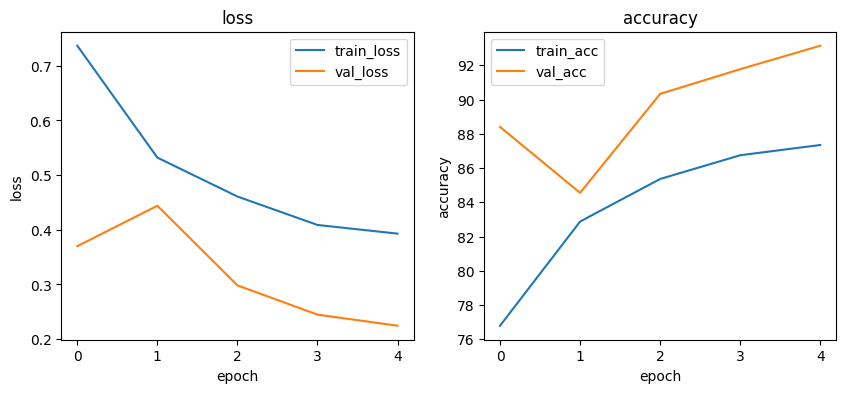

In [51]:
#Config for resnet18
hparams = {}
hparams['num_workers'] = 2
hparams['batch_size'] = 32
hparams['transforms_type'] = 'imagenet'
hparams['n_epochs'] = 5
hparams['learning_rate'] = 1e-3
hparams['optimizer'] = 'adam'
hparams['model_type'] = 'resnet18'
results, best_acc, best_model, test_loader = main(hparams)

#gather results
gather_results(results)

In [52]:
# Evaluate your best model on test set
evaluate(best_model, test_loader, criterion)

100%|██████████| 169/169 [00:04<00:00, 38.95it/s]


(0.23613954114693184, tensor(92.7778, device='cuda:0'))

# Task 5: Evaluate Model
Out of the models that you have trained and saved, pick one to be tested for quality. ***40%*** accuracy will pass the quality check.

***Hint:*** Use `load_model()` and  `evaluate()` previously defined.

_Points:_ 5

In [53]:
# YOUR CODE GOES HERE
...

# loss, accuracy = ...

# print(accuracy)
criterion = nn.CrossEntropyLoss()

test_loss, test_accuracy = evaluate(best_model_final, test_loader, criterion)

print(f"Final Test Accuracy: {test_accuracy:.2f}%")

best_hparams = {'model_type': 'model2'}

save_model(best_hparams, best_model_final)
# Save your best model
save_model(hparams, best_model)


100%|██████████| 169/169 [00:02<00:00, 56.77it/s]


Final Test Accuracy: 52.13%
model2 Model successfully saved to ./models/best_model.pth
resnet18 Model successfully saved to ./models/best_model.pth


# Suggestions


*   We have not asked you to sweep through two very important hyper-parameters: `learning_rate` and `n_epochs`. You can choose to do so by first fixing other hyper-parameters and decide on a reasonable values of `learning_rate` and `n_epochs` by observing the loss curves.
*   We have demonstrated a simple `baseline` model and a fine-tuned `ResNet18` model for this project. You can compare the performance of your designed models and expect the test performance to fall within the range between these models.



# Submission Guide
#### NOTE: Submit (1) main.ipynb, (2) best_model.pth and (3) hyper_sweep_results.csv to gradescope

# Credits
Adapted from a notebook originally prepared by **Ankur Mahesh** and **Isabelle Tingzon**.

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.

# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]